# Setting folder

In [10]:
%pwd

'/workspace/source'

# Import

In [11]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import albumentations as A
# import albumentations.pytorch as Ap

from torchvision import transforms
import torchvision.models as models

from utils import load_all_set

## seed value

In [12]:
IN_HEIGHT, IN_WIDTH = 224, 224

RESOURCE = "GPU"

RANDOM_SEED = 46

EPOCH = 100
BATCH_SIZE =  64
lr = 1e-3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# Install dataset

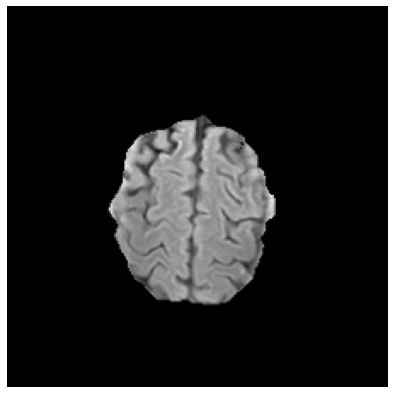

In [13]:
x_train, y_train, x_val, y_val, x_test, y_test = load_all_set()

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')

In [14]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [15]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:
dataset_train = MyDataset(xs=x_train, ys=y_train, transforms=transforms_train)
dataset_val = MyDataset(xs=x_val, ys=y_val, transforms=transforms_val)

train_n = len(dataset_train)
val_n = len(dataset_val)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

# Model compile

In [17]:
model = models.resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Sequential(nn.Linear(2048,1))
model.add_module('sigmoid', nn.Sigmoid())
model = model.to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Train

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(EPOCH):
    model.train()

    tr_loss = 0
    correct = 0
    total = 0

    train_time_start = time.time()

    step = 0
    batch_accuracy = 0
    for inputs, targets in tqdm(dataloader_train):
        optimizer.zero_grad()

        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss = loss / n_batch
        loss.backward()

        loss = loss.item()
        tr_loss += loss / train_n

        optimizer.step()
        
        b_outputs = outputs.squeeze().cpu().detach().numpy().copy()
        b_targets = targets.squeeze().cpu().detach().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

    train_losses.append(tr_loss)
    train_accuracy = batch_accuracy/step
    train_accuracies.append(train_accuracy)

    train_time_end = time.time()

    model.eval()

    val_loss = 0
    val_correct = 0
    val_total= 0

    val_time_start = time.time()

    step = 0
    batch_accuracy = 0
    with torch.no_grad():
        for val_inputs, val_targets in dataloader_val:
            
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(torch.float32)
            val_targets = val_targets.to(device)
            
            val_outputs = model(val_inputs)

            loss = criterion(val_outputs, val_targets)

            val_loss += loss.item() / val_n

            b_outputs = val_outputs.squeeze().cpu().numpy().copy()
            b_targets = val_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    val_accuracy = batch_accuracy / step
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    val_time_end = time.time()
    train_time = train_time_end - train_time_start
    val_time = val_time_end - val_time_start
    total_time = train_time + val_time

    print(f"epoch:{epoch+1}/{EPOCH} [train]loss{tr_loss:.6f} acc:{train_accuracy:.4f}, [val]loss:{val_loss:.6f}, acc:{val_accuracy:.4f}")

    if (epoch+1) % 10 == 0:
        plt.figure(figsize=(7,10))
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()


  0%|          | 0/141 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/Loss.cu:115: operator(): block: [0,0,0], thread: [43,0,0] Assertion `input_val >= zero && input_val <= one` failed.


RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

# Test

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MyDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.eval()

step = 0
batch_accuracy = 0
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step

print(f'{100*test_accuracy:.2f}%')


86.64%
